
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import numpy as np
import pandas as pd
import re
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)
all_countries_df = s.load_object('all_countries_df').set_index('country_code', drop=True)


----


# Prepare the Countries scatterplot


## Get the Country Youth Female Literacy Rate data

In [3]:

if s.pickle_exists('literacy_countries_df'):
    literacy_countries_df = s.load_object('literacy_countries_df')
else:
    url = 'https://www.indexmundi.com/facts/indicators/SE.ADT.1524.LT.FE.ZS/rankings'
    tables_list = ssu.get_page_tables(url)
    literacy_countries_df = tables_list[0].copy()
    # print(literacy_countries_df.columns.tolist())
    literacy_countries_df.columns = ['literacy_rank', 'country_name', 'literacy_rate', 'survey_year']
    for cn in ['literacy_rate']:
        literacy_countries_df[cn] = literacy_countries_df[cn].map(lambda x: re.sub(r'[^0-9\.]+', '', str(x)))
        literacy_countries_df[cn] = pd.to_numeric(literacy_countries_df[cn], errors='coerce', downcast='float')
    display(literacy_countries_df.head(5))
    
    # Remove country misspellings
    literacy_countries_df.country_name = literacy_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
    countries_list = sorted(set(literacy_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
    if countries_list:
        print(countries_list)
    doubles_df = ssu.check_4_doubles(countries_list)
    mask_series = (doubles_df.max_similarity > 0.6)
    if doubles_df[mask_series].shape[0]:
        columns_list = ['first_item', 'second_item', 'max_similarity']
        display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))
    
    # Remove country duplicates
    mask_series = literacy_countries_df.duplicated(subset=['country_name'], keep=False)
    if literacy_countries_df[mask_series].shape[0]:
        display(literacy_countries_df[mask_series].sort_values('country_name'))
    
    # These countries cause redditors to make hurtful comments *sniff*
    country_set = set(all_countries_df.country_name) - set(ssu.derisable_countries_list)
    mask_series = literacy_countries_df.country_name.isin(country_set)
    literacy_countries_df = literacy_countries_df[mask_series]
    
    literacy_countries_df['natural_log_of_literacy_rate'] = literacy_countries_df.literacy_rate.map(lambda x: np.log(x))
    s.store_objects(literacy_countries_df=literacy_countries_df)


## Get the Country Fertility Rate data

In [4]:

if s.pickle_exists('fertility_countries_df'):
    fertility_countries_df = s.load_object('fertility_countries_df')
else:
    tables_list = ssu.get_page_tables('../data/html/world_bank_fertility_rate_by_country.html')
    fertility_countries_df = tables_list[0].copy()
    # print(fertility_countries_df.columns.tolist())
    columns_list = ['country_name', 'survey_year', 'fertility_rate']
    fertility_countries_df.columns = columns_list
    for cn in ['fertility_rate']:
        fertility_countries_df[cn] = fertility_countries_df[cn].map(lambda x: re.sub(r'[^0-9\.]+', '', str(x).split(' ')[0]))
        fertility_countries_df[cn] = pd.to_numeric(fertility_countries_df[cn], errors='coerce', downcast='float')
    mask_series = fertility_countries_df.country_name.isnull() | fertility_countries_df.fertility_rate.isnull()
    fertility_countries_df = fertility_countries_df[~mask_series][columns_list]
    
    # Remove country misspellings
    fertility_countries_df.country_name = fertility_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
    countries_list = sorted(set(fertility_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
    if countries_list:
        print(countries_list)
    doubles_df = ssu.check_4_doubles(countries_list)
    mask_series = (doubles_df.max_similarity > 0.6)
    if doubles_df[mask_series].shape[0]:
        columns_list = ['first_item', 'second_item', 'max_similarity']
        display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))
    
    # Remove country duplicates
    mask_series = fertility_countries_df.duplicated(subset=['country_name'], keep=False)
    if fertility_countries_df[mask_series].shape[0]:
        display(fertility_countries_df[mask_series].sort_values('country_name'))
        
    # These countries cause redditors to make hurtful comments *sniff*
    country_set = set(all_countries_df.country_name) - set(ssu.derisable_countries_list)
    mask_series = fertility_countries_df.country_name.isin(country_set)
    fertility_countries_df = fertility_countries_df[mask_series]
    
    fertility_countries_df['natural_log_of_fertility_rate'] = fertility_countries_df.fertility_rate.map(lambda x: np.log(x))
    s.store_objects(fertility_countries_df=fertility_countries_df)


# Create the Country scatterplot

In [5]:

# Explanatory variable
xname = 'fertility_rate'
xlabel_str = 'Youth Female Fertility Rate (2020)'

# Response variable
yname = 'literacy_rate'
ylabel_str = 'Youth Female Literacy Rate (2020)'

# Remove NaNs
columns_list = ['country_name', xname, yname]
df = literacy_countries_df.merge(fertility_countries_df, on='country_name', how='inner')[columns_list].dropna()
title_str = 'Scatterplot of Literacy vs Fertility'

xdata = df[xname]
xmin = xdata.min()
xmin_fstr = '{} (least fertile)'
xmax = xdata.max()
xmax_fstr = '{} (most fertile)'

ydata = df[yname]
ymin = ydata.min()
ymin_fstr = '{} (least literate)'
ymax = ydata.max()
ymax_fstr = '{} (most literate)'

In [6]:

df.sample(5)

,country_name,fertility_rate,literacy_rate
61,Ecuador,2.4,99.089996
58,North Macedonia,1.3,99.160004
79,Israel,2.9,98.050003
80,St. Vincent & Grenadines,1.9,98.000000
107,Nepal,1.8,90.879997


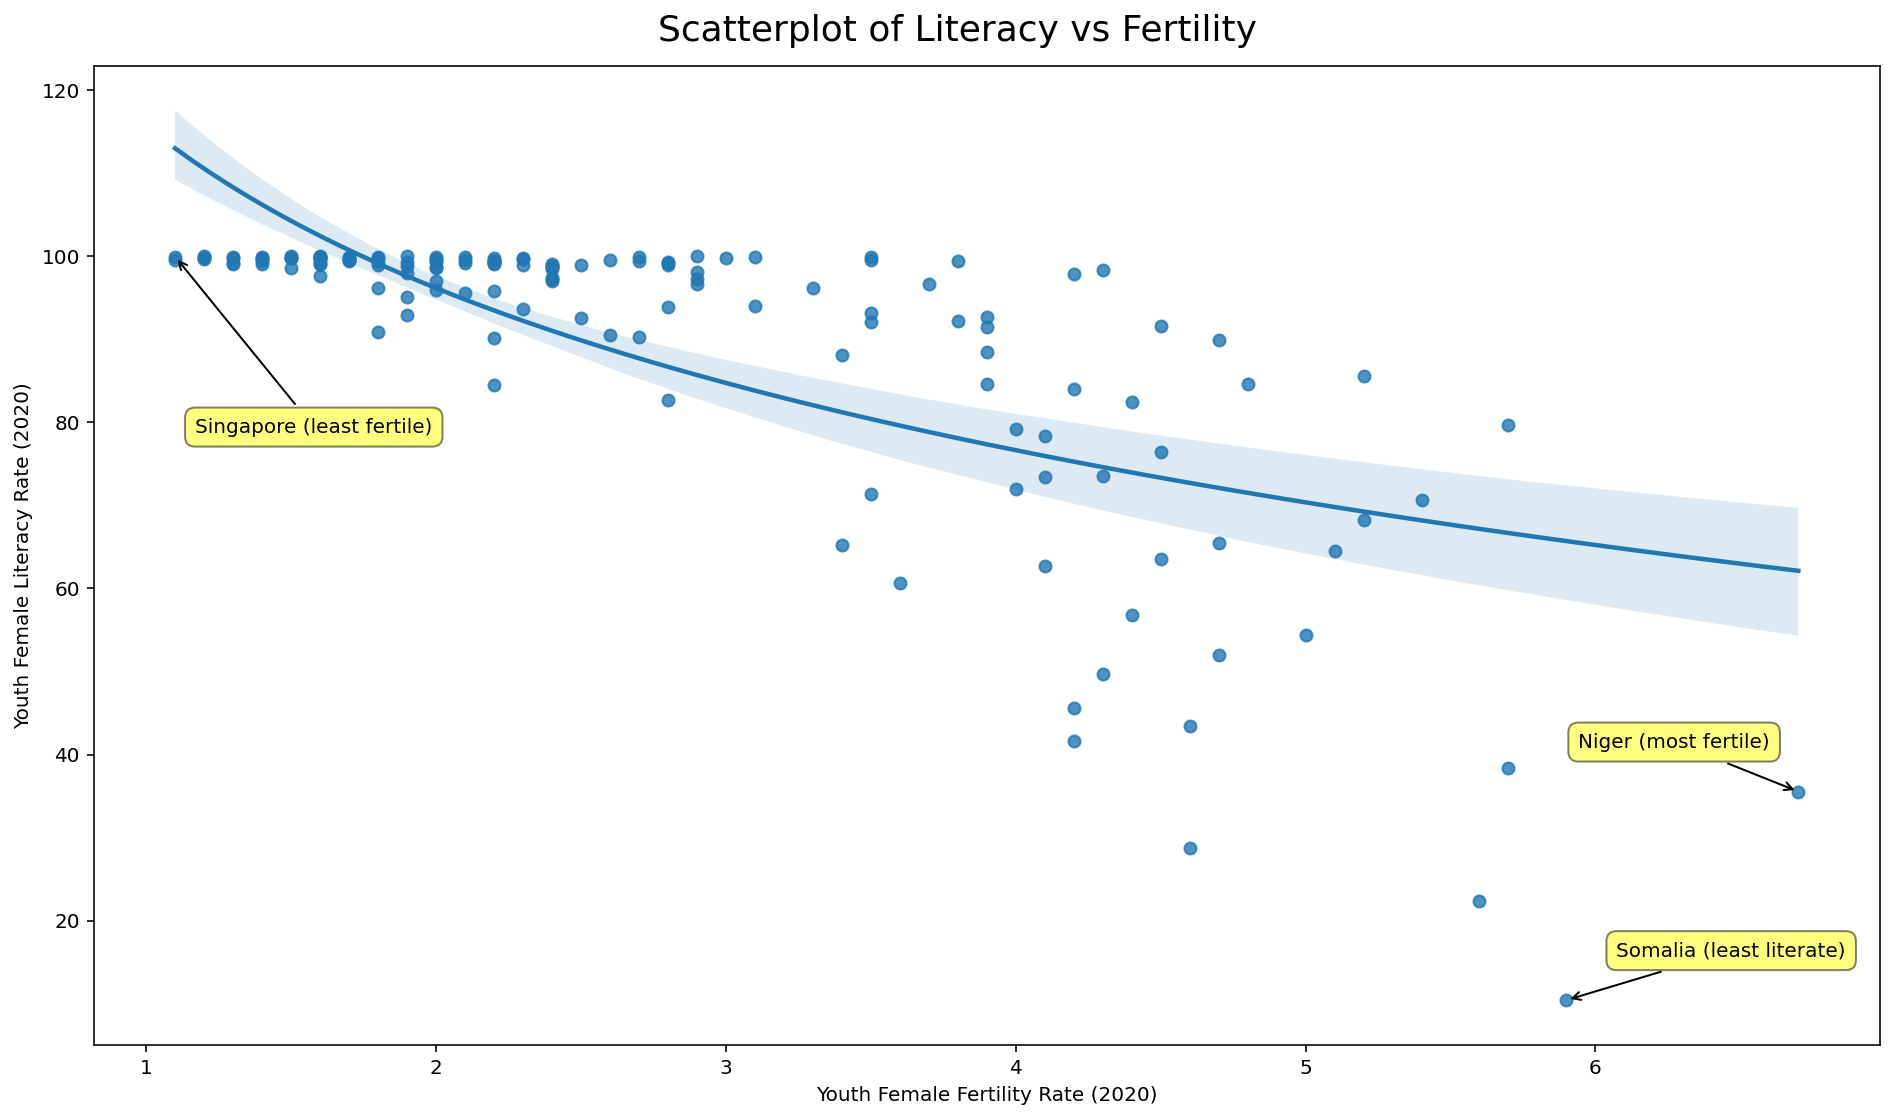

In [9]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(16, 9))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df, logx=True)
xlabel_text = plt.xlabel(xlabel_str)
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
already_annotated = False
for label, x, y in zip(df['country_name'], xdata, ydata):
    if (y == ymin):
        annotation = plt.annotate(ymin_fstr.format(label),
                                  xy=(x, y), xytext=(25, 20), **kwargs)
    elif (x == xmax):
        annotation = plt.annotate(xmax_fstr.format(label),
                                  xy=(x, y), xytext=(-110, 20), **kwargs)
    elif (x == xmin) and not already_annotated:
        already_annotated = True
        annotation = plt.annotate(xmin_fstr.format(label),
                                  xy=(x, y), xytext=(10, -90), **kwargs)

# Add r-squared
# plt.text(6.5, 110, r'$r^2 = {0:.2}$'.format(pearsonr(xdata, ydata)[0] ** 2), fontsize=20, alpha=0.25,
#          horizontalalignment='center', verticalalignment='center')

title_obj = fig.suptitle(title_str, fontsize=18, y=0.92)